In [11]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl

import neuro_morpho_toolbox as nmt

%matplotlib inline

## Plotting test

In [12]:
[ns] = pickle.load(open("neuron_set.pickle", 'rb'))
[metadata] = pickle.load(open("metadata.pickle", 'rb'))


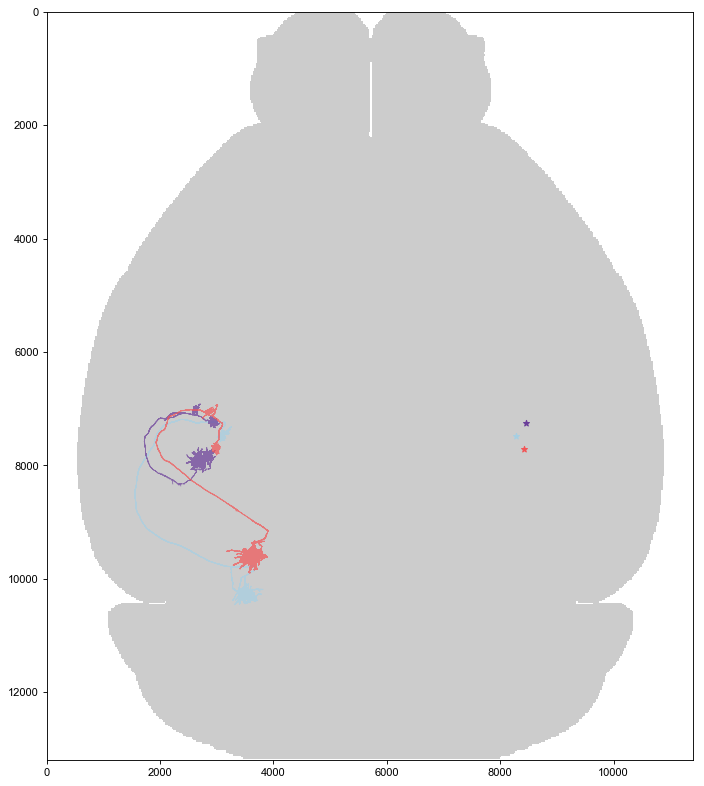

In [13]:
from neuro_morpho_toolbox.plot import cell_in_map

test_list = metadata[metadata.Celltype == "LGd"].index.tolist()
cell_in_map(ns.neurons, test_list[:3], metadata, ccf_annotation=nmt.annotation, view="Horizontal", color="single_cell")

## Feature 1: projection patterns

In [56]:
ns = nmt.neuron_set('../Data/swc/mapped/Data_for_analysis/swc/Whole/')

Loading...
number of files under swc_path: 285
100 loaded: 3.6s
200 loaded: 4.1s
Finding soma locations...
Getting projection features...
Number of input neurons: 284
Number of input features: 632
Getting dendrite features...
Number of input neurons: 284
Number of input features: 316
All values are zeros for the following cells:
18457_00009
Getting metadata...


/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/neuron_features.py:337: RuntimeWarning:

invalid value encountered in true_divide



## metadata

In [11]:
# df = pd.read_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_08082019.xlsx", index_col=[0])
# metadata = ns.features['soma_features'].region
# df = df.loc[metadata.index]
# df.to_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_08082019.284_cells.xlsx")

In [14]:
df = pd.read_excel("../Subjective_celltype/tracking_table.284_cells.xlsx", index_col=[0])
region_list = pd.read_excel("../Subjective_celltype/tracking_table.284_cells.xlsx", sheet_name=1, header=None)[2].tolist()

metadata = ns.features['soma_features'].region.copy()
metadata['Celltype'] = df.loc[metadata.index, "Confirmed"]
# # metadata['Celltype_note'] = df.loc[metadata.index, "Lijuan Note"]
# # metadata.loc[metadata["Celltype_note"]=="CPU", "Celltype"] = "CPU"
metadata.fillna("Others", inplace=True)
metadata.loc[metadata.Celltype.isin(["TH", "VPM/VPL"]), "Celltype"] = "TH_Uncertain"
metadata.loc[~metadata.Celltype.isin(["Others", "TH_Uncertain"]+region_list), "Celltype"] = "Others"
print(metadata.Celltype.value_counts())
# metadata
pickle.dump([metadata], open("metadata.pickle", "wb"))

CPU             128
VPM              34
LGd              34
Others           27
MG               21
VPL              19
LP                6
TH_Uncertain      5
AM                2
VAL               2
MD                2
IMD               1
VM                1
PO                1
PCN               1
Name: Celltype, dtype: int64


## Color setting

In [15]:
bupu = cl.scales['9']['seq']['BuPu']
greens = cl.scales['9']['seq']['Greens']
set2 = cl.scales['7']['qual']['Set2']
spectral = cl.scales['9']['div']['Spectral']
paired = cl.scales['10']['qual']['Paired']
mpl_colors = []
for i in range(9):
    tp = []
    for j in list(matplotlib.colors.to_rgb("C"+str(i))):
        tp.append(str(int(j*255)))
    tp = ", ".join(tp)
    tp = "rgb(" + tp + ")"
    mpl_colors.append(tp)
   
def rgb_to_list(rgb_str):
    tp = rgb_str.replace("rgb(", "").replace("rgba(", "").replace(")", "")
    res = [float(i)/255 for i in tp.split(", ")]
    return res

def get_celltype_colors(metadata):
    u_celltypes = sorted(list(set(metadata.Celltype)))
    color_list = cl.to_rgb(cl.interp(paired, len(u_celltypes)))
    color_list = [rgb_to_list(i) for i in color_list]
    celltype_colors = dict(zip(u_celltypes, color_list))
    if "Others" in u_celltypes:
        celltype_colors["Others"] = rgb_to_list('rgb(128, 128, 128)')
    return celltype_colors

celltype_color_dict = get_celltype_colors(metadata)

pickle.dump([celltype_color_dict], open("colors.pickle", "wb"))

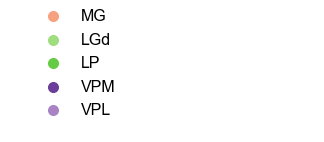

In [18]:
fig, ax = plt.subplots(1,1,figsize=(5,2))
selected_regions = ['MG', 'LGd', 'LP', 'VPM', 'VPL']
# for i, key in enumerate(list(celltype_color_dict.keys())):
for i, key in enumerate(selected_regions):
    ax.scatter(0.001, len(celltype_color_dict) - i, c=celltype_color_dict[key], s=100)
    ax.text(0.002, len(celltype_color_dict) - i, key, 
            horizontalalignment='left',
            verticalalignment="center",
            fontdict={"size":16}
           )
    ax.set_xlim(0, 0.01)
    ax.axis("off")

In [20]:
ns.metadata["CellType"] = metadata.loc[ns.metadata.index, "Celltype"]
clusters = pd.read_csv("clusters.csv", index_col=[0])
ns.metadata['Cluster'] = clusters.loc[ns.metadata.index, "Cluster"]
ns.metadata["CellType_note"] = metadata.loc[ns.metadata.index, "Celltype_note"]

In [22]:
pickle.dump([ns], open("neuron_set.pickle", "wb"))

In [8]:
ns.features['projection_features'].normalize(log=True)
pickle.dump([ns.features['projection_features']], open("features_projection.pickle", "wb"))

## Feature 2: soma locations

In [11]:
pickle.dump([ns.features['soma_features']], open("features_soma.pickle", "wb"))

## Feature 3: axon morphological features

In [93]:
# 1. Axon overall
df1 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df1.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df1 = df1[use_cols]

feature_name = use_cols
new_feature_name = ['A_'+i.replace(' ', '_') for i in use_cols]
df1.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)


In [94]:
# 2. Local axon
df2 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/proximal_axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df2.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df2 = df2[use_cols]

feature_name = use_cols
new_feature_name = ['AL_'+i.replace(' ', '_') for i in use_cols]
df2.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

In [95]:
df = pd.concat([df1, df2], axis=1)
lm_axon = nmt.features("L-measure of axon")
lm_axon.add_raw_data(df)

pickle.dump([lm_axon], open("features_lm_axon.pickle", "wb"))

Number of input neurons: 284
Number of input features: 32


## Feature 4: dendrite morphological features

In [97]:
df = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/dendrite.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df = df[use_cols]

feature_name = use_cols
new_feature_name = ['D_'+i.replace(' ', '_') for i in use_cols]
df.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

lm_dendrite = nmt.features("L-measure of dendrite")
lm_dendrite.add_raw_data(df)

pickle.dump([lm_dendrite], open("features_lm_dendrite.pickle", "wb"))

Number of input neurons: 284
Number of input features: 16


## neuron_set for plotting

In [5]:
ns_resample = nmt.neuron_set('../Data/swc/mapped/Data_for_analysis/swc/Whole/resample/')

Loading...
number of files under swc_path: 285
100 loaded: 0.8s
200 loaded: 0.8s
Finding soma locations...
Getting projection features...
Number of input neurons: 284
Number of input features: 632
Getting dendrite features...
Number of input neurons: 284
Number of input features: 316
All values are zeros for the following cells:
18457_00009
Getting metadata...


/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/neuron_features.py:337: RuntimeWarning:

invalid value encountered in true_divide



In [9]:
pickle.dump([ns_resample], open('neuron_set_resample.pickle', 'wb'))